In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as lin
import scipy.signal as sig
from PIL import Image
import glob
import matplotlib.cm as cm
import itertools

In [3]:
########### Load Input ############################################################################################################################
# In this script I used the brightness to determine structures, instead of one RGB color:
# this is determined by: 0.2126*R + 0.7152*G + 0.0722*B
# Source: https://en.wikipedia.org/wiki/Relative_luminance

patchSize=40 # patchsize this must be 48 since our network can only handle this value

# Open forest
Amount_data= len(glob.glob('Forest/F*'))
dataPatchedF=[]
for k in range (0, Amount_data):
    name="Forest/F%d.png" % (k+1)
    img = Image.open(name)
    data=img.convert('RGB')
    data= np.asarray( data, dtype="int32" )
    data=0.2126*data[:,:,0]+0.7152*data[:,:,1]+0.0722*data[:,:,2]
    Yamount=data.shape[0]/patchSize # Counts how many times the windowsize fits in the picture
    Xamount=data.shape[1]/patchSize # Counts how many times the windowsize fits in the picture
    dataPatchedF.append(np.array([[data[j*patchSize:(j+1)*patchSize,i*patchSize:(i+1)*patchSize] for i in range(0,Xamount)] for j in range(0,Yamount)]))

# Open city
Amount_data= len(glob.glob('City/C*'))
dataPatchedC=[]
for k in range (0, Amount_data):
    name="City/C%d.png" % (k+1)
    img = Image.open(name)
    data=img.convert('RGB')
    data = np.asarray( data, dtype="int32" )
    data=0.2126*data[:,:,0]+0.7152*data[:,:,1]+0.0722*data[:,:,2]
    Yamount=data.shape[0]/patchSize # Counts how many times the windowsize fits in the picture
    Xamount=data.shape[1]/patchSize # Counts how many times the windowsize fits in the picture    
    dataPatchedC.append(np.array([[data[j*patchSize:(j+1)*patchSize,i*patchSize:(i+1)*patchSize] for i in range(0,Xamount)] for j in range(0,Yamount)]))

# Open water
dataPatchedW=[]
Amount_data= len(glob.glob('Grassland/G*'))
for k in range (0, Amount_data): 
    name="Grassland/G%d.png" % (k+1)
    img = Image.open(name)
    data=img.convert('RGB')
    data = np.asarray( data, dtype="int32" )
    data=0.2126*data[:,:,0]+0.7152*data[:,:,1]+0.0722*data[:,:,2]
    Yamount=data.shape[0]/patchSize # Counts how many times the windowsize fits in the picture
    Xamount=data.shape[1]/patchSize # Counts how many times the windowsize fits in the picture
    dataPatchedW.append(np.array([[data[j*patchSize:(j+1)*patchSize,i*patchSize:(i+1)*patchSize] for i in range(0,Xamount)] for j in range(0,Yamount)])) 
    

In [4]:
########### Functions ############################################################################################################################

# Define Activitation functions, pooling and convolution functions (the rules)

def Sigmoid(x): 
    return (1/(1+np.exp(-x)))

def SigmoidPrime(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

def TanH(x):
    return (1-np.exp(-x))/(1+np.exp(-x))


def Pool(I,W):
    PoolImg=np.zeros((len(I)/len(W),len(I)/len(W))) # W must fit an integer times into I.
    for i in range(0,len(PoolImg)):
        for j in range(0,len(PoolImg)):
            SelAr=I[i*len(W):(i+1)*len(W),j*len(W):(j+1)*len(W)]
            PoolImg[i,j]=np.inner(SelAr.flatten(),W.flatten()) # Now this is just an inner product since we have vectors
    return PoolImg

# To automatically make Gaussian kernels
def makeGaussian(size, fwhm = 3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

# To automatically define pooling nodes
def Pool_node(N):
    s=(N,N)
    a=float(N)*float(N)
    return (1.0/a)*np.ones(s) 



In [5]:
#################### Define pooling layers ###########################################################################
P12=Pool_node(4)*(1.0/1.0000) #factor 1000 added to lower values more
P34=Pool_node(2)*(1.0/1.0) 

#################### Define Convolution layers #######################################################################

######### First C layer #########
C1=[]
Kernelsize=9
## First Kernel

# Inspiration: http://en.wikipedia.org/wiki/Sobel_operator
# http://stackoverflow.com/questions/9567882/sobel-filter-kernel-of-large-size




Kernel=np.array([[3,2,1,0,0,0,-1,-2,-3],
                 [4,3,2,1,0,-1,-2,-3,-4], 
                 [5,4,3,2,0,-2,-3,-4,-5],
                 [6,5,4,3,0,-3,-4,-5,-6], 
                 [7,6,5,4,0,-4,-5,-6,-7],
                 [6,5,4,3,0,-3,-4,-5,-6],
                 [5,4,3,2,0,-2,-3,-4,-5],
                 [4,3,2,1,0,-1,-2,-3,-4],
                 [3,2,1,0,0,0,-1,-2,-3]])
                 

C1.append(Kernel*(1.0/100.0))

# ## Third Kernel
# Kernel=makeGaussian(9,5)
# Kernel=(1/np.sum(Kernel))*Kernel
# C1.append(Kernel)


## Fourth Kernel
Kernel=np.zeros((Kernelsize,Kernelsize))
Kernel[0:4,:]=-5
Kernel[4:5,:]=0
Kernel[5:9,:]=5    
C1.append(Kernel*(1.0/100.0))
        
## Fifth kernel
Kernel=np.transpose(C1[0])  
C1.append(Kernel*(1.0/100.0))

## kernel
Kernel=np.zeros((Kernelsize,Kernelsize))
Kernel[3:6,3:6]=-2 
Kernel[4,4]=8
C1.append(Kernel*(1.0/100.0))

## kernel
Kernel=np.transpose(C1[1])
C1.append(Kernel)


######### Initialize output weights and biases #########

# Initialisation, since this layer should be trained!
C2=[] # second convolution weigths
H3_bias=[]
W=[] # end-weight from output to classifier-neurons
# Define the number of branches in one row
N_branches=3
ClassAmount=3 # Forest, City, Water


for i in range (0, len(C1)):
    C2_kernel=np.random.rand(N_branches,3,3)*(1.0/100.0)
    C2.append(C2_kernel)
    H3_bias.append(np.random.rand(N_branches,1,1))
    W.append(np.random.rand(N_branches,ClassAmount,3,3)*(1.0/1000.0)) # W[r][b,k,:,:]

bias=np.zeros((ClassAmount))# bias on the three classes

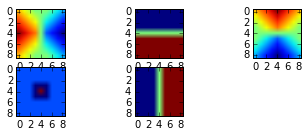

In [6]:
N_plts=len(C1)
for i in range(0,N_plts):
    plt.subplot(4,3,i+1)
    plt.imshow(C1[i])    

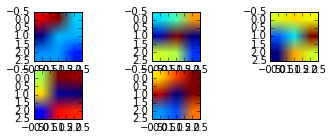

In [7]:
N_plts=len(C2)
for i in range(0,N_plts):
    plt.subplot(4,3,i+1)
    plt.imshow(C2[i][0])   

In [8]:
#################### Start training  #######################################################################

# Determines which patch is chosen when
N_F=len(dataPatchedF)
Patches_F=[]
j=0;
for i in range(0,N_F):
    N_ff=dataPatchedF[i].shape[0]*dataPatchedF[i].shape[1]
    Patches_F.append(np.reshape(dataPatchedF[i], (N_ff, patchSize, patchSize)))
    j=j+N_ff
N_F=j

N_C=len(dataPatchedC)
Patches_C=[]
j=0;
for i in range(0,N_C):
    N_cc=dataPatchedC[i].shape[0]*dataPatchedC[i].shape[1]
    j=j+N_cc
    Patches_C.append(np.reshape(dataPatchedC[i], (N_cc, patchSize, patchSize)))
N_C=j

N_W=len(dataPatchedW)
Patches_W=[]
j=0;
for i in range(0,N_W):
    N_ww=dataPatchedW[i].shape[0]*dataPatchedW[i].shape[1]
    Patches_W.append(np.reshape(dataPatchedW[i], (N_ww, patchSize, patchSize)))
    j=j+N_ww
N_W=j

N_total=N_F+N_C+N_W
Sequence = np.arange(N_total)
Sequence = np.random.permutation(Sequence)

# Make patches tractable
Patches_F = list(itertools.chain.from_iterable(Patches_F))
Patches_F=np.asarray(Patches_F)

Patches_C = list(itertools.chain.from_iterable(Patches_C))
Patches_C=np.asarray(Patches_C)

Patches_W = list(itertools.chain.from_iterable(Patches_W))
Patches_W=np.asarray(Patches_W)


In [9]:
len(Sequence)

21560

In [10]:
int(np.round(len(Sequence)*0.9))

19404

In [26]:
from itertools import product
right=np.zeros((3))
wrong=np.zeros((3))
###### Chooses patch and defines label #####
for PP in range(5000,int(np.round(len(Sequence)*0.9))):
       # 1 has to be changed to the number of training data
    SS=Sequence[PP]
    if SS<N_F:
        Class_label=np.array([1,0,0])
        inputPatch=Patches_F[SS]
    elif(SS>=N_F) and (SS<(N_F+N_C)):
        Class_label=np.array([0,1,0])
        inputPatch=Patches_C[SS-N_F]
    elif(SS>=N_F+N_C):
        Class_label=np.array([0,0,1])
        inputPatch=Patches_W[SS-N_F-N_C]
    else:continue

    ### Layer 1 ###
    H1=[]
    H2=[]
    H3=[[np.zeros((6,6)) for b in range(0,N_branches)] for r in range(0,len(C1))]
    H4=[[np.zeros((3,3)) for b in range(0,N_branches)] for r in range(0,len(C1))]
    I_H3=np.ones((6,6))
    x=np.zeros(ClassAmount)
    f=np.zeros(ClassAmount)
    #learning rates
    n_bias=1*10**-3
    n_W=1*10**-4
    n_C2=1*10**-4
    n_H3_bias=1*10**-5


    for r in range (0, len(C1)):
        H1.append(sig.convolve(inputPatch, C1[r], 'valid'))
        H2.append(Pool(H1[r], P12))
        for b in range(0,N_branches):
            H3[r][b]=Sigmoid(sig.convolve(H2[r], C2[r][b],'valid')-H3_bias[r][b]*I_H3)
            H4[r][b]=Pool(H3[r][b],P34)

    for k in range(0,ClassAmount):
        for r in range (0, len(C1)):
            for b in range(0,N_branches):
                x[k]=x[k]+np.inner(H4[r][b].flatten(),W[r][b,k].flatten())
        f[k]=Sigmoid(x[k]-bias[k])

    ###### Back-propagation #####
    for k in range(0, ClassAmount):
        bias[k]=bias[k]-n_bias*(Class_label[k]-f[k])
        for r in range (0, len(C1)):
            for b in range(0,N_branches):
                W[r][b,k]=W[r][b,k]+n_W*(Class_label[k]-f[k])*H4[r][b]
   
    if(np.argmax(f)==np.argmax(Class_label)):
        right[np.argmax(Class_label)]+=1
    else: 
        wrong[np.argmax(Class_label)]+=1
        
    if (PP%30==0):
#         print(Class_label,np.round(f,2))
        print(right,wrong)
    if (PP%250==0):
        print(PP)
        print(np.sum(right)/(np.sum(wrong)+np.sum(right)))
        right=np.zeros((3))
        wrong=np.zeros((3))
        



5000
1.0
(array([ 2.,  2.,  0.]), array([ 0.,  2.,  4.]))
(array([ 14.,   6.,   0.]), array([ 3.,  8.,  9.]))
(array([ 21.,   7.,   0.]), array([  6.,  10.,  26.]))
(array([ 30.,  15.,   0.]), array([  6.,  12.,  37.]))
(array([ 38.,  20.,   1.]), array([  7.,  20.,  44.]))
(array([ 47.,  24.,   3.]), array([  9.,  26.,  51.]))
(array([ 55.,  33.,   3.]), array([ 10.,  30.,  59.]))
(array([ 61.,  41.,   4.]), array([ 10.,  33.,  71.]))
(array([ 70.,  51.,   4.]), array([ 11.,  36.,  78.]))
5250
0.5
(array([ 8.,  7.,  0.]), array([ 4.,  5.,  6.]))
(array([ 19.,  12.,   0.]), array([  4.,   7.,  18.]))
(array([ 25.,  20.,   0.]), array([  5.,  12.,  28.]))
(array([ 36.,  27.,   0.]), array([  5.,  15.,  37.]))
(array([ 45.,  33.,   0.]), array([  6.,  17.,  49.]))
(array([ 52.,  40.,   1.]), array([  6.,  21.,  60.]))
(array([ 58.,  48.,   4.]), array([  7.,  25.,  68.]))
(array([ 67.,  56.,   4.]), array([ 10.,  26.,  77.]))
5500
0.52
(array([ 1.,  7.,  1.]), array([ 2.,  2.,  7.]))
(ar

KeyboardInterrupt: 

In [96]:
print(np.sum(right)/(np.sum(wrong)+np.sum(right)))

0.542483660131


# cross validation

In [27]:
right=np.zeros((3))
wrong=np.zeros((3))

plot=0
###### Chooses patch and defines label #####
i=0
j=0
for PP in range(int(np.round(len(Sequence)*0.9)),len(Sequence)):
     # 1 has to be changed to the number of training data
    SS=Sequence[PP]
    if SS<N_F:
        Class_label=np.array([1,0,0])
        inputPatch=Patches_F[SS]
    elif(SS>=N_F) and (SS<(N_F+N_C)):
        Class_label=np.array([0,1,0])
        inputPatch=Patches_C[SS-N_F]
    elif(SS>=N_F+N_C):
        Class_label=np.array([0,0,1])
        inputPatch=Patches_W[SS-N_F-N_C]
    else:continue

    ### Layer 1 ###
    H1=[]
    H2=[]
    H3=[[np.zeros((6,6)) for b in range(0,N_branches)] for r in range(0,len(C1))]
    H4=[[np.zeros((3,3)) for b in range(0,N_branches)] for r in range(0,len(C1))]
    I_H3=np.ones((6,6))
    x=np.zeros(ClassAmount)
    f=np.zeros(ClassAmount)
    #learning rates

    for r in range (0, len(C1)):
        H1.append(sig.convolve(inputPatch, C1[r], 'valid'))
        H2.append(Pool(H1[r], P12))
        for b in range(0,N_branches):
            H3[r][b]=Sigmoid(sig.convolve(H2[r], C2[r][b],'valid')-H3_bias[r][b]*I_H3)
            H4[r][b]=Pool(H3[r][b],P34)

    for k in range(0,ClassAmount):
        for r in range (0, len(C1)):
            for b in range(0,N_branches):
                x[k]=x[k]+np.inner(H4[r][b].flatten(),W[r][b,k].flatten())
        f[k]=Sigmoid(x[k]-bias[k])
        
    if(np.argmax(f)==np.argmax(Class_label)):
        right[np.argmax(Class_label)]+=1
    else: 
        wrong[np.argmax(Class_label)]+=1
    if (PP%40==0):
        print(right,wrong)
        print(np.sum(right)/(np.sum(wrong)+np.sum(right)))

(array([ 6.,  9.,  1.]), array([  1.,   4.,  16.]))
0.432432432432
(array([ 14.,  19.,   2.]), array([  5.,   9.,  28.]))
0.454545454545
(array([ 30.,  22.,   2.]), array([  7.,  17.,  39.]))
0.461538461538
(array([ 39.,  30.,   2.]), array([  7.,  25.,  54.]))
0.452229299363
(array([ 54.,  35.,   5.]), array([  9.,  27.,  67.]))
0.477157360406
(array([ 62.,  40.,   7.]), array([ 13.,  37.,  78.]))
0.459915611814
(array([ 73.,  46.,  10.]), array([ 13.,  47.,  88.]))
0.465703971119
(array([ 86.,  49.,  10.]), array([  15.,   51.,  106.]))
0.457413249211
(array([ 101.,   60.,   12.]), array([  18.,   52.,  114.]))
0.484593837535
(array([ 116.,   65.,   13.]), array([  23.,   57.,  123.]))
0.488664987406
(array([ 127.,   76.,   15.]), array([  25.,   60.,  134.]))
0.49885583524
(array([ 137.,   85.,   17.]), array([  30.,   67.,  141.]))
0.501048218029
(array([ 146.,   94.,   17.]), array([  33.,   70.,  157.]))
0.497098646035
(array([ 156.,  100.,   20.]), array([  34.,   77.,  170.]))


In [28]:
print(np.sum(right)/(np.sum(wrong)+np.sum(right)))

0.497217068646


In [29]:
print(right[0]/(right[0]+wrong[0]))

0.829817158931


In [30]:
print(right[1]/(right[1]+wrong[1]))

0.593794076164


In [31]:
print(right[2]/(right[2]+wrong[2]))

0.0828804347826


# save training parameters

In [51]:
import pickle
file = open('C2_michiel.txt', 'w')
pickle.dump(C2, file)
file.close()

import pickle
file = open('C1_michiel.txt', 'w')
pickle.dump(C1, file)
file.close()

file = open('W_michiel.txt', 'w')
pickle.dump(W, file)
file.close()

file = open('H3_bias_michiel.txt', 'w')
pickle.dump(H3_bias, file)
file.close()

file = open('bias_michiel.txt', 'w')
pickle.dump(bias, file)
file.close()
